# Add Cabbages to the Mark-Recapture model

Let:

N = Number of animals in the population

n = Number of animals marked on the first visit

K = Number of animals captured on the second visit

k = Number of recaptured animals that were marked

Chapman estimation equation:

𝑁̂ 𝐶=(𝐾+1)(𝑛+1)𝑘+1−1

### Changes vs previous version:
* All constants moved from global variables to a class, as class properties
* The model is made into a function
* The "running dots" visualization is made conditional (so we haven't deleted it completely), but it is now inactivated by default
* New constat added, named v_decay. That's because I changed the way they move. They are no longer dedicated moose, but they aren't diffusing deer either; they are something in-between. The speed is now calculated via a formula $v⃗ t+1=v⃗ t∗α+ξ⃗$, where α is a decay rate (v_decay), while ξ is noise. What happens with this formula, is that speed is now random (as in diffusion), but at the same time, if an animal started moving in a certain direction, it overall has a tendency to continue moving in same direction. (It happens if α is reasonably close to 1, while the standard deviation of ξ is reasonably small). Once you run the model, I think you'll appreciate the subtle changes in behavior it brings.
* Added "shoving x and y back into the rectangle" as an edge behavior, while retaining the "reflection behavior". We used to have it in the "diffusing deer" model, but then at some point replaced it with reflecting moosen. Now we have both, and I think it works best that way.
* Returned to the loop solution for comparing all animals to all cabbage, but also added a part that only compares animals to LIVE cabbage.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class Const:
    def __init__(self):
        self.N_max = 1000
        self.N_start = 20  # Original N
        self.n_steps = 100
        self.vmin = 0.01
        self.vmax = 0.05
        self.v_decay = 0.7 # To make movement more realistic
        
        self.hp_baby = 10
        self.hp_food = 5
        self.hp_reproduction = 30
        self.hp_birthcost = 10
        self.hp_leak = 0.5
        
        self.food_rate = 1
        self.eating_distance = 0.05
        self.n_food_max = 1000
        self.n_food_start = 100

In [12]:
# Build the model
def model(c, show_dots=False, n_trials=1):
    history = np.zeros((c.n_steps, n_trials))

    for i_trial in range(n_trials):
        # Allocate hp for all animals, but only first few are alive
        hp = np.zeros(c.N_max)
        hp[:c.N_start] = np.random.uniform(
            low=c.hp_baby, high=c.hp_reproduction, size=c.N_start)
        
        x = np.random.uniform(size=c.N_max)
        y = np.random.uniform(size=c.N_max)
        vx = np.random.uniform(size=c.N_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.N_max,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.N_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.N_max,low=0,high=2) - 1)
        
        # Add cabbage!
        foodx = np.ones(c.n_food_max)*-1
        foodx[:c.n_food_start] = np.random.uniform(size=c.n_food_start)
        foody = np.random.uniform(size=c.n_food_max) 
        # Y doen't matter because x=-1 is enough to move cabbage out of this world
        # What does this mean?
        
        n = np.zeros(c.n_steps) # current n
        
        # Plotting:
        if show_dots:
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) # No subplots actually, just creating axes
            plt.xlim((0,1));
            plt.ylim((0,1));
            fig.show()
            fig.canvas.draw()
            
        for t in range(c.n_steps):
            # Move animals around:
            x += vx
            y += vy
            
            vx = vx*c.v_decay + np.random.randn(c.N_max)*c.vmin 
            vy = vy*c.v_decay + np.random.randn(c.N_max)*c.vmin
            # ^^^-------------- Make them run around (keeps speed somewhat randomized)
            
            # Reflect from the walls:
            vx = np.where(np.logical_or(x<0, x>1), -vx, vx)
            vy = np.where(np.logical_or(y<0, y>1), -vy, vy)
            x = np.maximum(0,np.minimum(x,1)) # <------------------- Keep them in enclosure
            y = np.maximum(0,np.minimum(y,1))
            
            for i_animal in range(c.N_max):
                if hp[i_animal]<=0: # Skip dead animals
                    continue
                # Version with a loop:
                for i_food in range(c.n_food_max):
                    if foodx[i_food]<0: # <------------------- This makes things faster
                        continue
                    d = np.sqrt((x[i_animal]-foodx[i_food])**2 + (y[i_animal]-foody[i_food])**2)
                    if d < c.eating_distance:
                        hp[i_animal] += c.hp_food
                        foodx[i_food] = -1
                
            # Let cabbage grow!
            potential_cabbage = np.argwhere(foodx<0)
            if potential_cabbage.size != 0:
                foodx[potential_cabbage[0]] = np.random.uniform()
                foody[potential_cabbage[0]] = np.random.uniform()
                
            hp -= c.hp_leak # Death
            
            n[t] = np.sum(hp>0)
            
            if show_dots: # Actual animation
                ax.clear()
                plt.plot(x[hp>0], y[hp>0], 'k.',markersize=5);
                plt.plot(foodx,foody,'r.', markersize=2)
                plt.xlim((0,1));
                plt.ylim((0,1));
                fig.canvas.draw() # Redraws the canvas (key secret command to animate things)
        # --- Time loop is over

        history[:,i_trial] = n
    return np.mean(history, axis=1)
            

<IPython.core.display.Javascript object>


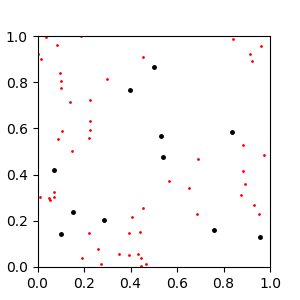

<IPython.core.display.Javascript object>


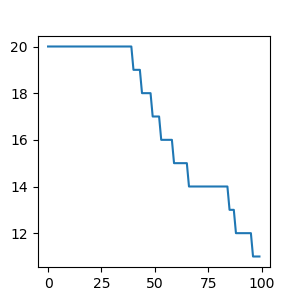

In [15]:
c = Const()
curve = model(c, show_dots=True);
plt.figure(figsize=(3,3));
plt.plot(curve);